In [68]:
# using CairoMakie
using Plots
using Interpolations
using WriteVTK

In [69]:
mutable struct Dot
    id::Int32
    
    x::Float32
    y::Float32
    
    dxcum::Float32
    dycum::Float32
    
    x_old::Float32
    y_old::Float32
    
    
    sector::Int32
    group::Int32
end


# mutable struct Dot2
#     x::Float32
#     y::Float32
    
    
#     sector::Int32
#     group::Int32
# end

In [70]:
# d = Dot(1,1,1,1,1,1,1)

In [71]:
function default_dot(id::Int, x::Float32, y::Float32)
    d = Dot(id,x,y,0,0,0,0,1,1)    
end
function default_dot(id::Int, x::Float64, y::Float64)
    default_dot(id,convert(Float32, x), convert(Float32, y))
end

default_dot (generic function with 2 methods)

In [72]:
npoints = 1000
dots = Vector{Dot}(undef,npoints)

for i in 1:npoints
    dots[i] = default_dot(i,rand(Float32),rand(Float32))
#    d.x = rand(Float32)
#    d.y = rand(Float32)    
end

In [73]:
dots[1:10]

10-element Vector{Dot}:
 Dot(1, 0.7697711f0, 0.8493788f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(2, 0.16549116f0, 0.27985603f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(3, 0.82498664f0, 0.117468536f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(4, 0.44319427f0, 0.6836919f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(5, 0.8236994f0, 0.5633438f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(6, 0.066280246f0, 0.79664963f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(7, 0.14437789f0, 0.09272224f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(8, 0.8737763f0, 0.29476774f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(9, 0.49157107f0, 0.046314f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)
 Dot(10, 0.41583264f0, 0.36907554f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 1, 1)

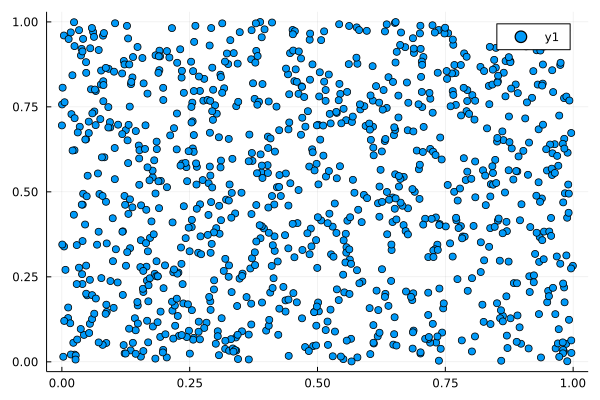

In [74]:
xs = [d.x for d in dots];
ys = [d.y for d in dots];

scatter(xs,ys)

In [75]:
# rand(1:10,3)

min_distance = 0.02

# plotattr(:Plot)

# xs = [min_distance, min_distance*2, 5]
# fs = [min_distance*2,min_distance,0]

# interp = LinearInterpolation(xs, fs)
# xs2 = min_distance:0.01:3
# ys = interp(xs2);
# scatter(xs2,ys)
# plot!(xs,fs)

x = 0.01:0.01:2
# y = log.(x)
y = (1 ./x.^2+1e3*log.(x)) ./1e3 ;
# plot(x,y)

In [113]:
function force(r)
    m = 0.1
   if r< min_distance
        return min_distance*m
    end
#         return -interp(r)*m
#     end
    if r>1
        return 0
    end
    y = -r/(-0.1+r)^2
end

force (generic function with 1 method)

In [114]:
xs = 0:0.1:3;
ys = [force(z) for z in xs];

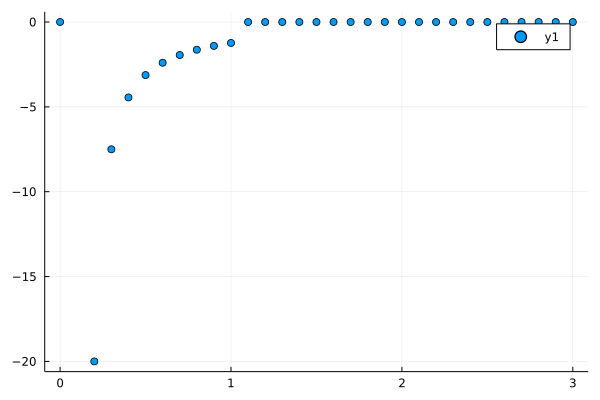

In [115]:
scatter(xs,ys)

In [79]:
d = 0.5
force(d)

-0.6891471805599453

In [80]:
function update_points!(p1::Dot, p2::Dot, temperature = 1e-1)
    dx = p2.x - p1.x + 1e-5
    dy = p2.y - p1.y
    d = (dx^2 + dy^2)^(1/2)
    θ = dx>0 ? atan(dy,dx) : atan(-dy,-dx) + π
    r = force(d)*temperature
    if r ==0
        return
    end
    y_mid = (p1.y+p2.y)/2
    x_mid = (p1.x+p2.x)/2
    
    # cum is cummulative. Add up all the movements before actually moving. 
    f = sin
    p1.dycum -= f(θ)*r/2 
    p2.dycum += f(θ)*r/2      
    
    f = cos    
    p1.dxcum -= f(θ)*r/2
    p2.dxcum += f(θ)*r/2      
end




function step!(dots, temperature = 1e-1)
#     pairs_to_select = 1000
#    idxs =  rand(1:npoints,pairs_to_select)
#    idxs2 =  rand(1:npoints,pairs_to_select)    
#     idxs = 1:npoints
#     idxs2 = reverse(1:npoints)    
#     for (i,j) in zip(idxs, idxs2)
    for i in 1:npoints
        for j in i:npoints
            if i == j
                continue
            end
           update_points!(dots[i], dots[j], temperature)
        end
    end
end

step! (generic function with 2 methods)

In [81]:
n_steps =2
n_points_track = 1000
XS = zeros(Float32, n_points_track, n_steps)
YS = zeros(Float32, n_points_track, n_steps)
start_temp = 1
end_temp = 1e-1
for i in 1:n_steps
    
    xs = [d.x for d in dots[1:n_points_track]]
    ys = [d.y for d in dots[1:n_points_track]]
    
    XS[:,i] = xs
    YS[:,i] = ys
    
    temperature = -(start_temp-end_temp)/n_steps*i+start_temp
    
    step!(dots,temperature)
    
    i % 10 ==0 ? println("step $i, temperature = $temperature") : nothing
    
    
end

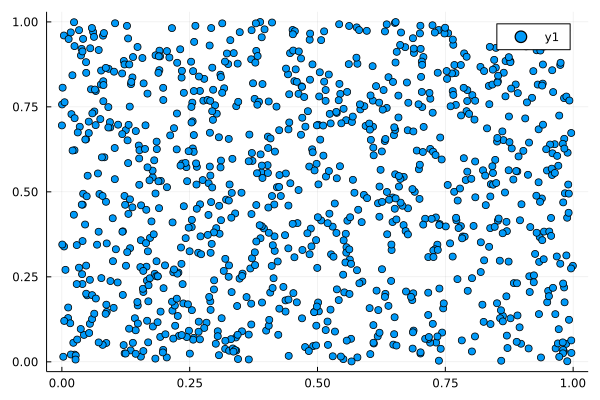

In [82]:
xs = [d.x for d in dots[1:n_points_track]];
ys = [d.y for d in dots[1:n_points_track]];

scatter(xs,ys)

In [83]:
# xs

In [84]:
# XS;

In [85]:
# p = rand(100, 100, 100)
# vtk_write_array("filename", p, "Pressure")
# vtk_write_array("filename", (XS, YS), ("x", "y"))

In [86]:
add_dim(x::Array) = reshape(x, (size(x)...,1))

add_dim (generic function with 1 method)

In [87]:
using DelimitedFiles

In [88]:
# ?writedlm

In [89]:
# saved_files = paraview_collection("full_simulation") do pvd
ids = collect(1:n_points_track)
    for i in 1:n_steps
#     for i in 1:5
    
         xs = add_dim(XS[:,i] )
         ys =  add_dim(YS[:,i] )
    
#         vtk_write_array("vtk/filename_$i", (xs, ys), ("x", "y"))        
        points  = hcat(ids,xs,ys)
#         println(size(points))
#         vtk_write_array("vtk/filename_$i", (xs, ys), ("x", "y"))
#         vtk_write_array("vtk/filename_$i",points,"coords")        
    writedlm( "vtk/points_$i.csv",  points, ',')
# writedlm( "vtk/YS.csv",  transpose(YS), ',')
    
    
#         vtk_grid("timestep_$n", x, y, z) do vtk
#             vtk["Pressure"] = rand(length(x), length(y), length(z))
#             pvd[time] = vtk
#         end
    end
# end

In [90]:

# writedlm( "vtk/XS.csv", transpose( XS), ',')
# writedlm( "vtk/YS.csv",  transpose(YS), ',')

In [91]:



# small = 1e-9

#         x1 = xs[i]#+small
#         x2 = xs[j]
#         y1 = ys[i]#+small
#         y2 = ys[j]
#         dx = x2 - x1
#         dy = y2 - y1
#         d = (dx.^2 + dy.^2).^(1/2)
# #         theta = atan.(dy./dx)
#         θ = dx>0 ? atan(dy,dx) : atan(-dy,-dx) + π
        
        
#         dy_dx = dy./dx
#         s = sin(θ)
#         c = cos(θ)
#         println("($x1,$y1) and ($x2, $y2)\t with theta $θ and d = $d. s,c = ($s,$c)")
#     end
# end


In [101]:
xss = [-1, 1, 1, -1] ./4
yss = [-1, -1, 1, 1] ./4

xss = xss[1:2]
yss = yss[1:2]


dots = []
for (xs,ys) in zip(xss,yss)
   d = default_dot(1,xs,ys)
    push!(dots, d)
end

In [103]:
temperature=1
for i in 1:size(dots,1)
    j = 1
#     for j in 1:4
        if i == j; continue ;end
           update_points!(dots[i], dots[j], temperature)
        
#     end
end

function move_points!(dots)
    for d in dots
        d.x_old = d.x
        d.y_old = d.y
        
        d.x = d.x+d.dxcum
        d.y = d.y+d.dycum
        
        d.dxcum = 0
        d.dycum = 0
    end
end

move_points! (generic function with 1 method)

In [104]:
move_points!(dots)

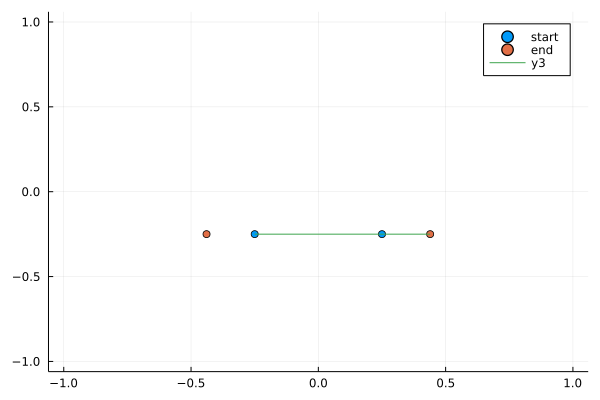

In [106]:
x1s = [d.x_old for d in dots]
y1s = [d.y_old for d in dots]

x2s = [d.x for d in dots]
y2s = [d.y for d in dots]

scatter(x1s,y1s, label = "start")
p = scatter!(x2s,y2s, label = "end")
for i in 1:1
    p =plot!([x1s[i],x2s[i]], [y1s[i], y2s[i]])
end
p
xaxis!(lims = [-1,1])
yaxis!(lims = [-1,1])